In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

pd.set_option('display.max_columns', 50)
RAND_STATE = 42

In [264]:
# set up device agnostic code
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### DataLoaders Don't Work w/ Apple Silicon Macs out of the box yet!
# if torch.backends.mps.is_available:
#     DEVICE = 'mps'

print('Using',DEVICE, 'for computations')

Using cpu for computations


---

# Loading The Data

We will use the `Breast Cancer Wisconsin Data Set` from UCIrvine for this project which can be found on [Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)


In [265]:
# load raw train data
df = pd.read_csv('data/breast_cancer_wisconsin.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


---

# Data Preparation and Cleaning

1. In this section we will check for several possibilities.  
    1. Check the description of data
    1. Check for missing values
    1. Check for duplicate entries
1. Then, we will drop the columns with no information
1. Finally, we will encode the categorical columns (in this case `diagnosis`) into numerical format.

In [266]:
# 1.1. check data description
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


In [267]:
# 1.2. checking for missing values
print(df.isna().any())

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

In [268]:
# 1.3. checking for duplicate entries
print(df[df.duplicated()])

Empty DataFrame
Columns: [id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, Unnamed: 32]
Index: []


In [269]:
# 2. drop columns with no information
df = df.drop(columns=['Unnamed: 32'])
df = df.drop(columns=['id'])

In [270]:
# 3. encoding the target column
    # M (Malignant) -> 1
    # B (Benign) -> 0

df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0}) 

In [271]:
# chack data types
df.dtypes # all columns are in numerical format

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

---

# Data Visualization
Data visualization section includes
- Feature Distribution
- Correlation Matrix

## Feature Distribution
In this section we will visualize the distribution of target classes as well as some other features

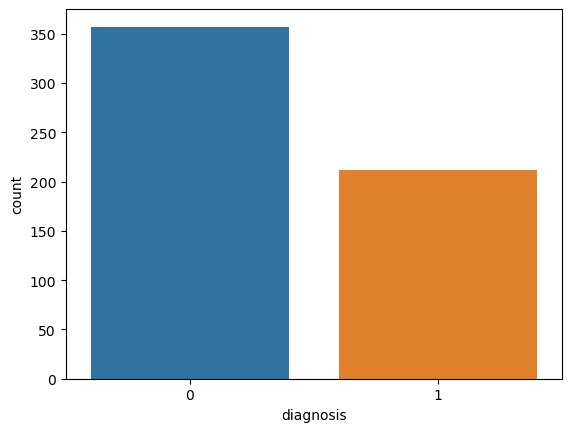

In [272]:
# target distribution
sns.countplot(x=df['diagnosis']);

## Feature Correlation
The correlation matrix shows a few highly correlated features which we will eliminate later. We will also plot the correlation of features with the target column.

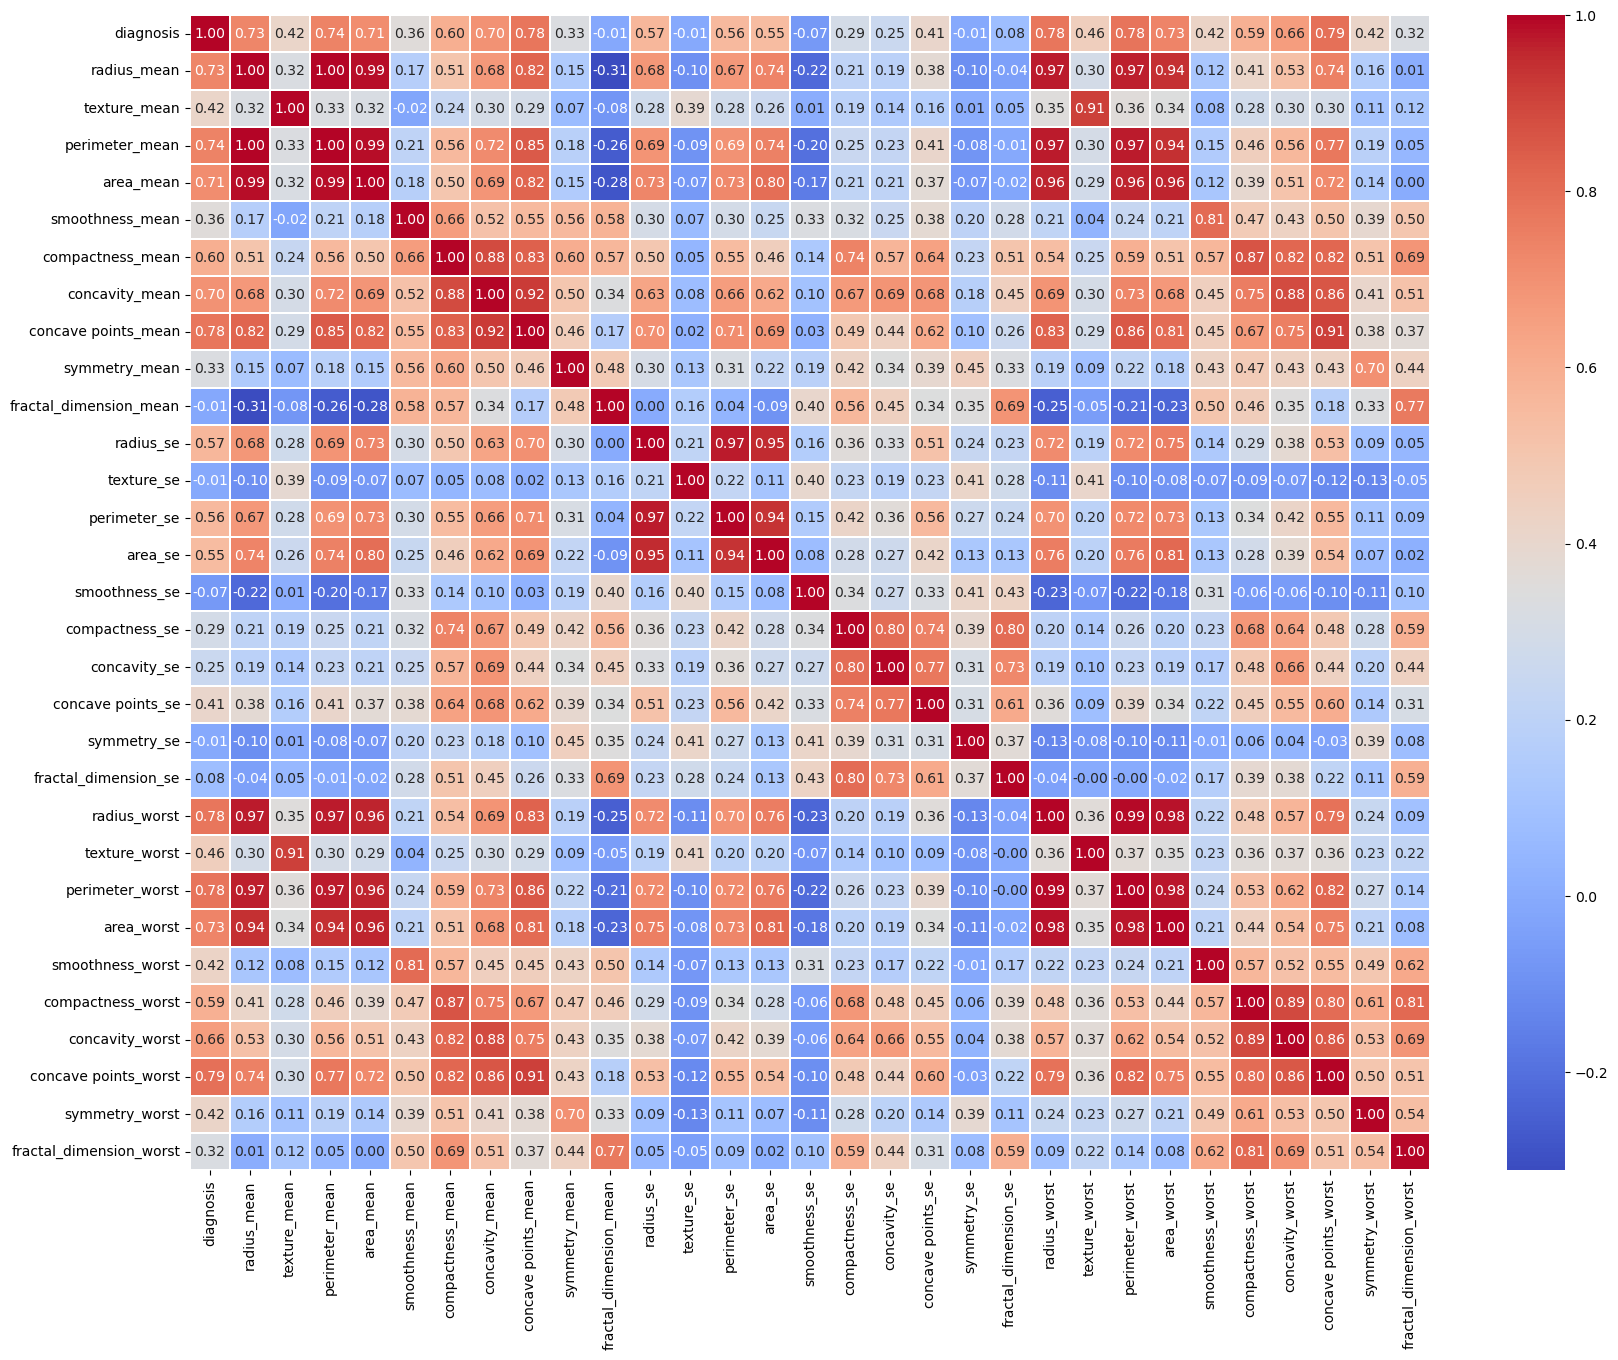

In [273]:
# correlation matrix
fig = plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=format('.2f'), linewidths=0.003);

---

# Feature Selection with Threshold
In order to eliminate features with high correlation, we will first define a `THRESHOLD` (the default being 0.85) and plot the feature tuples that have higher correlation value. We will then drop columns that are highly correlated and keep one.

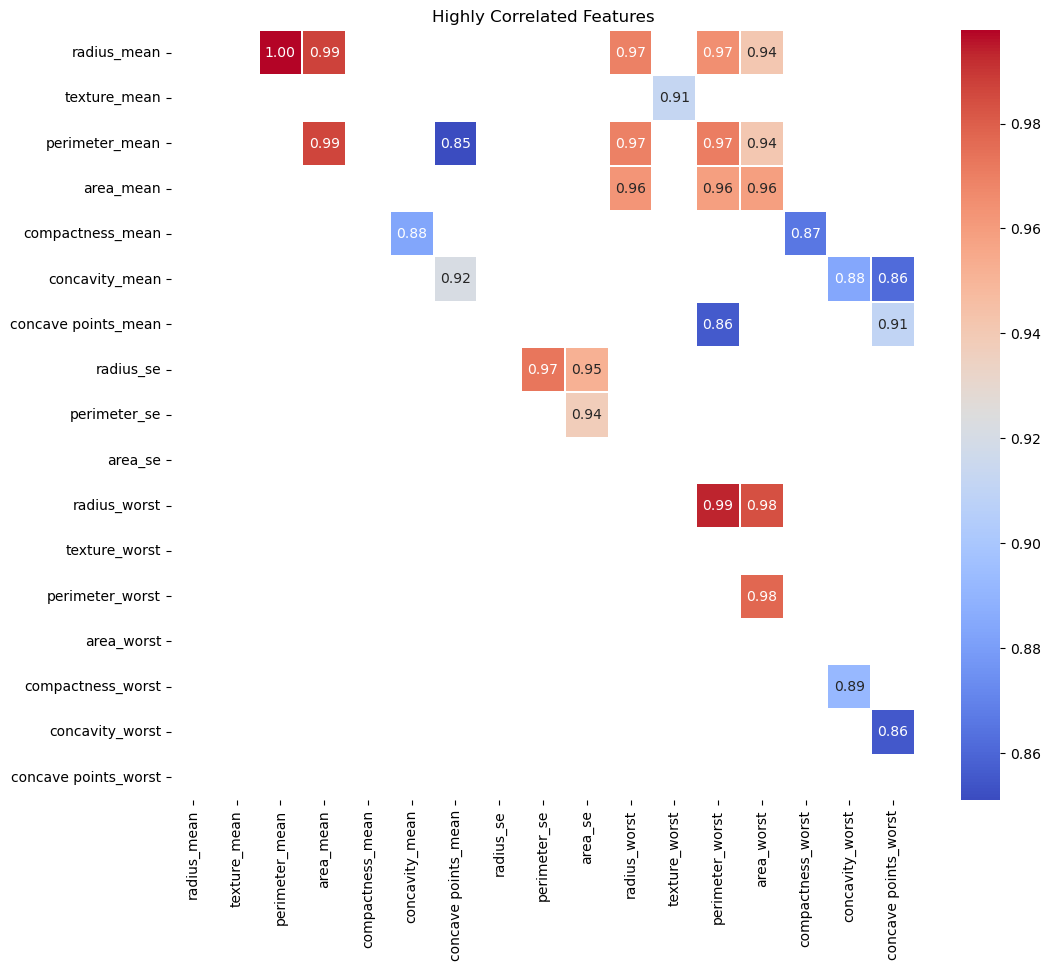

In [274]:
# find highly correlated features
THRESHOLD = 0.85
correlation_mat = df.corr()
for row in correlation_mat.index:
    for col in correlation_mat.columns:
        if row==col or correlation_mat.loc[row,col].round(2)<THRESHOLD:
            correlation_mat.loc[row,col] = np.nan
fig = plt.figure(figsize=(12,10))
highly_correlated = correlation_mat.dropna(how='all').dropna(axis=1,how='all')
mask = np.tril(np.ones_like(highly_correlated))
sns.heatmap(highly_correlated, cmap='coolwarm', mask=mask,annot=True, fmt=format('.2f'), linewidths=0.003)
plt.title('Highly Correlated Features');

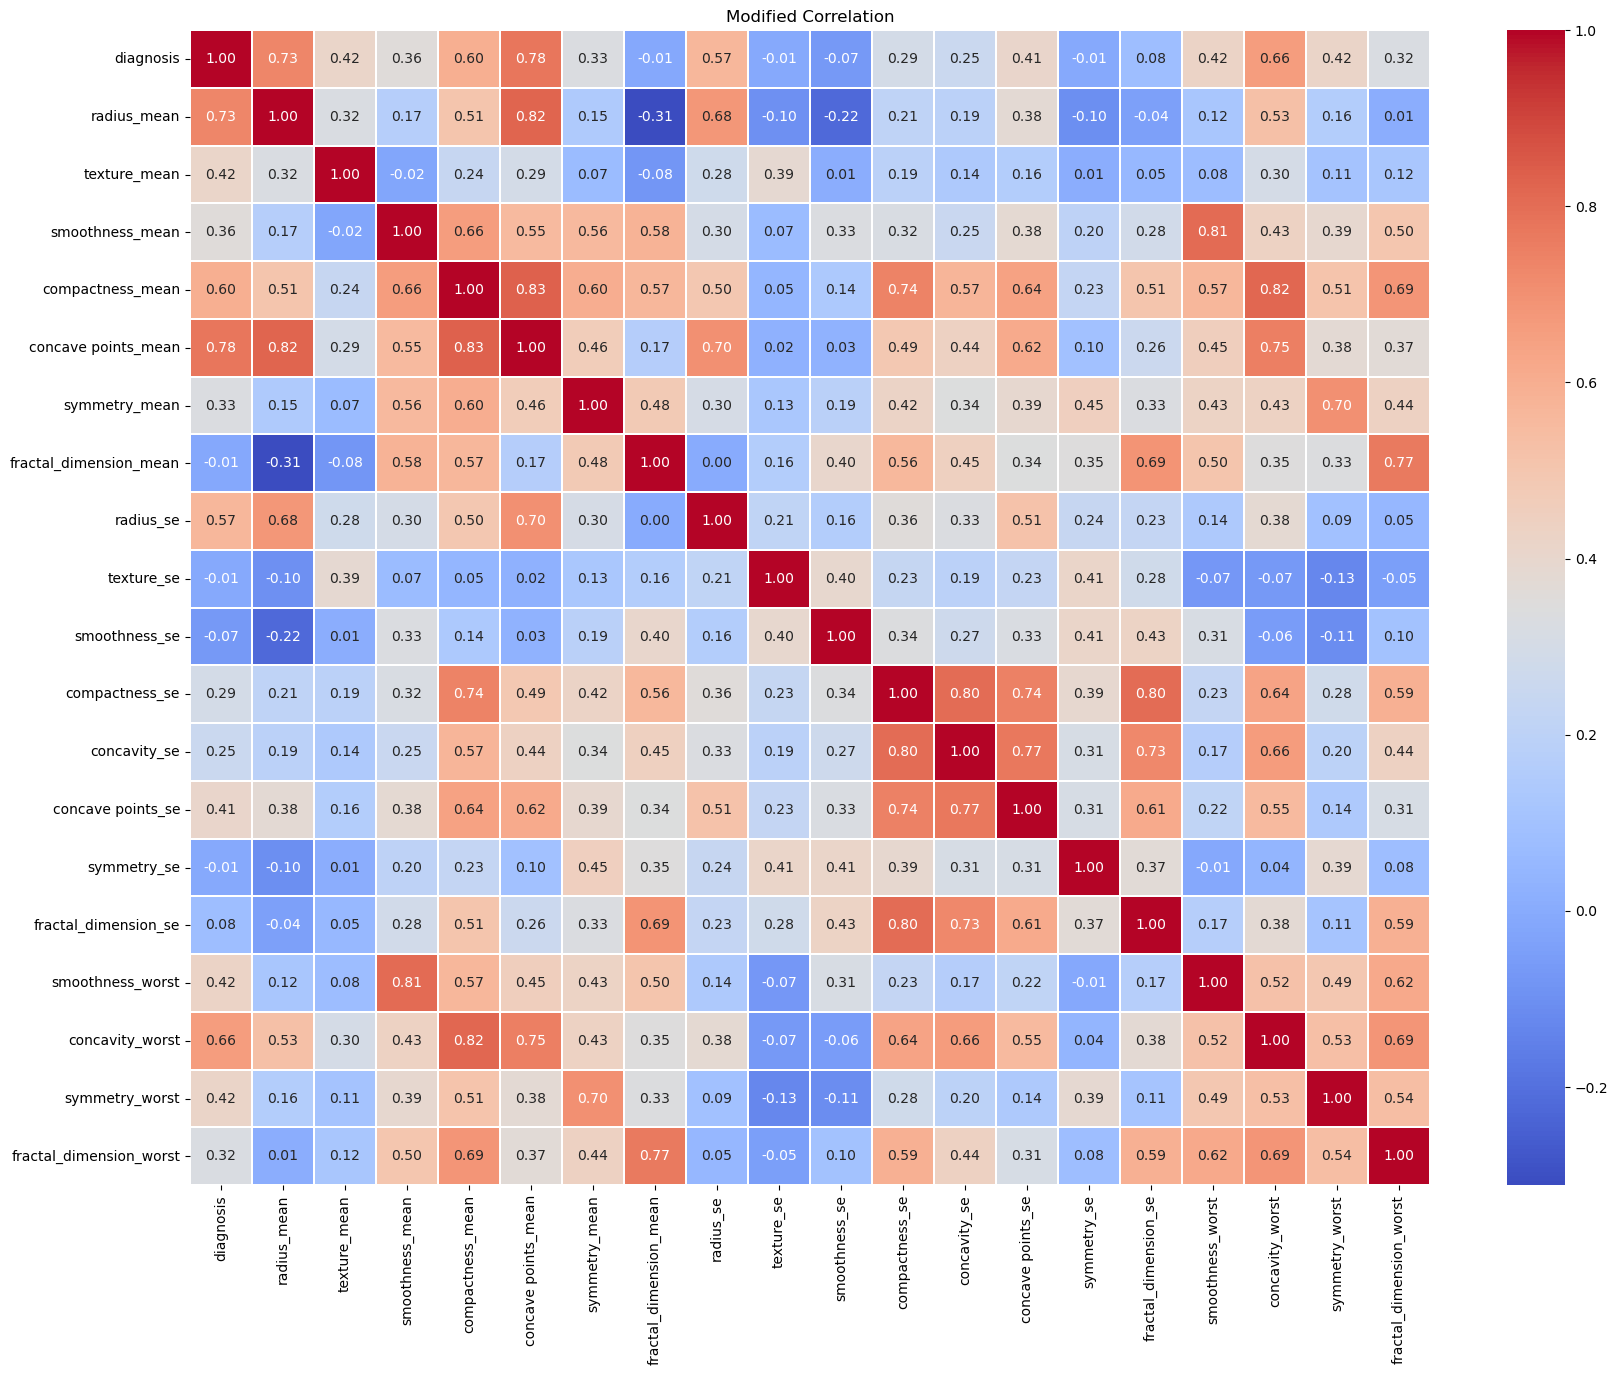

In [275]:
# Manual Feature Extraction Results
features_to_drop = ['perimeter_mean', #
                    'area_mean', #
                    'perimeter_se',
                    'perimeter_worst', #
                    'area_worst', #
                    'radius_worst', #
                    'texture_worst', #
                    'area_se',
                    'concave points_worst',
                    'concavity_mean',
                    'compactness_worst',]

df_corr_ext = df.drop(columns=features_to_drop)
correlation_mat = df_corr_ext.corr()
fig = plt.figure(figsize=(20,15))
sns.heatmap(correlation_mat, cmap='coolwarm',annot=True, fmt=format('.2f'), linewidths=0.003)
plt.title('Modified Correlation');

<Axes: >

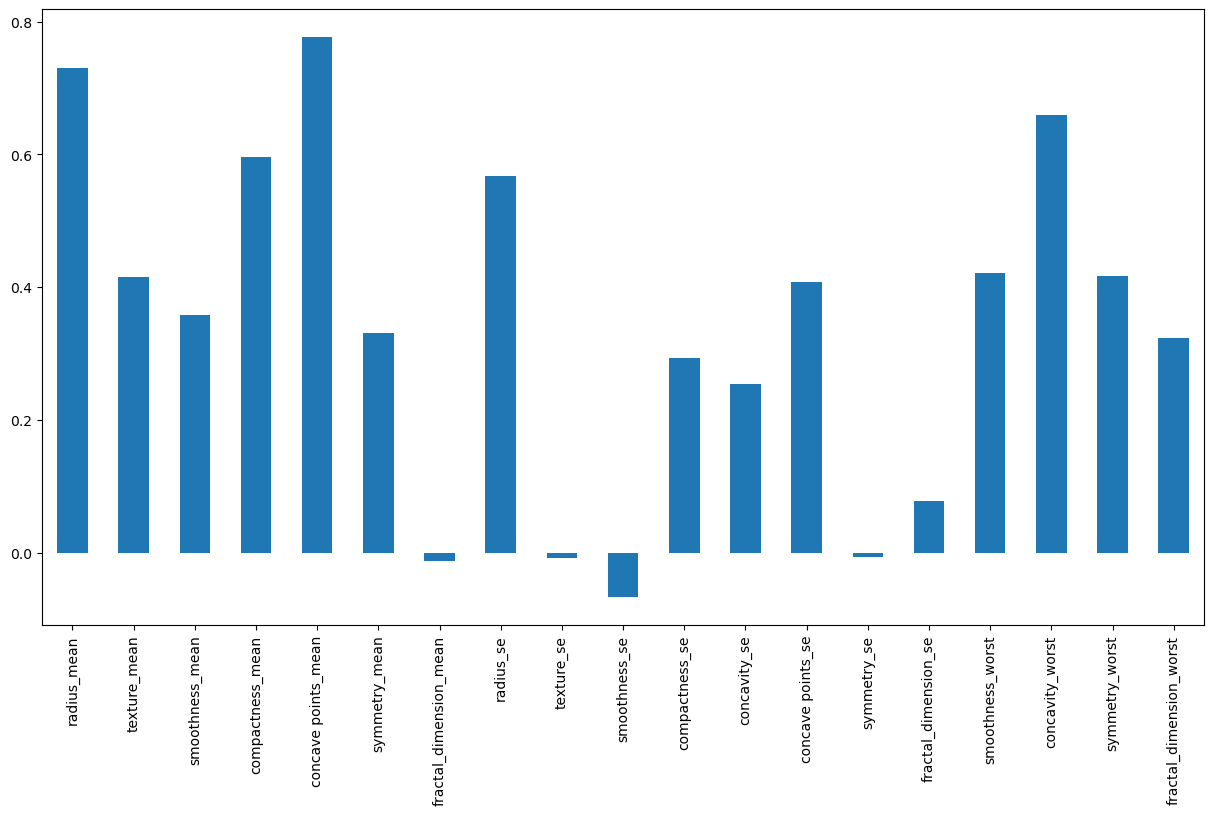

In [276]:
# correlation of features with target
target_corr = correlation_mat['diagnosis'].drop(['diagnosis'])
target_corr.plot(kind='bar', figsize=(15,8))

---

# Preparation for Model Feeding

We will prepare the data to input the models
1. Split the data into `train`, `validation` and `test` parts.
1. Create neccessary `transforms`.
1. Turn each portion into a PyTorch `Dataset`.
1. Generate train, validation and test `DataLoader`s.

In [277]:
# split the data set into train and test portions
from sklearn.model_selection import train_test_split

X = df_corr_ext.drop(columns=['diagnosis'])
y = df_corr_ext['diagnosis']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND_STATE)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=RAND_STATE)

print('Training Split:',len(X_train), len(y_train))
print('Validation Split:',len(X_validation), len(y_validation))
print('Testing Split:',len(X_test), len(y_test))

Training Split: 386 386
Validation Split: 69 69
Testing Split: 114 114


In [278]:
# standardizing features
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# separating target from the rest
scaler = StandardScaler()
fit_std = scaler.fit(X_train)
X_train_std = fit_std.transform(X_train)
X_validation_std = fit_std.transform(X_validation)
X_test_std = fit_std.transform(X_test)

# dimension reduction using pca
pca = PCA(n_components='mle') # we use Minka's Maximum Likelihood Estimation method
fit_pca = pca.fit(X_train_std)
X_train_pca = fit_pca.transform(X_train_std)
X_validation_pca = fit_pca.transform(X_validation_std)
X_test_pca = fit_pca.transform(X_test_std)

norm = MinMaxScaler()
fit_nrm = norm.fit(X_train_pca)
X_train_pca= fit_nrm.transform(X_train_pca)
X_validation_pca = fit_nrm.transform(X_validation_pca)
X_test_pca= fit_nrm.transform(X_test_pca)


pd.DataFrame(X_train_pca).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,386.0,0.287782,0.154721,0.0,0.177469,0.258077,0.378663,1.0
1,386.0,0.432435,0.129084,0.0,0.360490,0.431934,0.499114,1.0
2,386.0,0.419707,0.136924,0.0,0.336861,0.415931,0.495624,1.0
3,386.0,0.470106,0.102956,0.0,0.424937,0.467747,0.524853,1.0
4,386.0,0.493580,0.134517,0.0,0.415871,0.496592,0.578952,1.0
5,386.0,0.499154,0.136861,0.0,0.410332,0.491385,0.571156,1.0
6,386.0,0.471735,0.076346,0.0,0.432700,0.472630,0.511083,1.0
7,386.0,0.446817,0.093662,0.0,0.389212,0.444468,0.497013,1.0
8,386.0,0.458021,0.108466,0.0,0.390793,0.452458,0.515481,1.0
9,386.0,0.465005,0.134934,0.0,0.389689,0.474666,0.540408,1.0


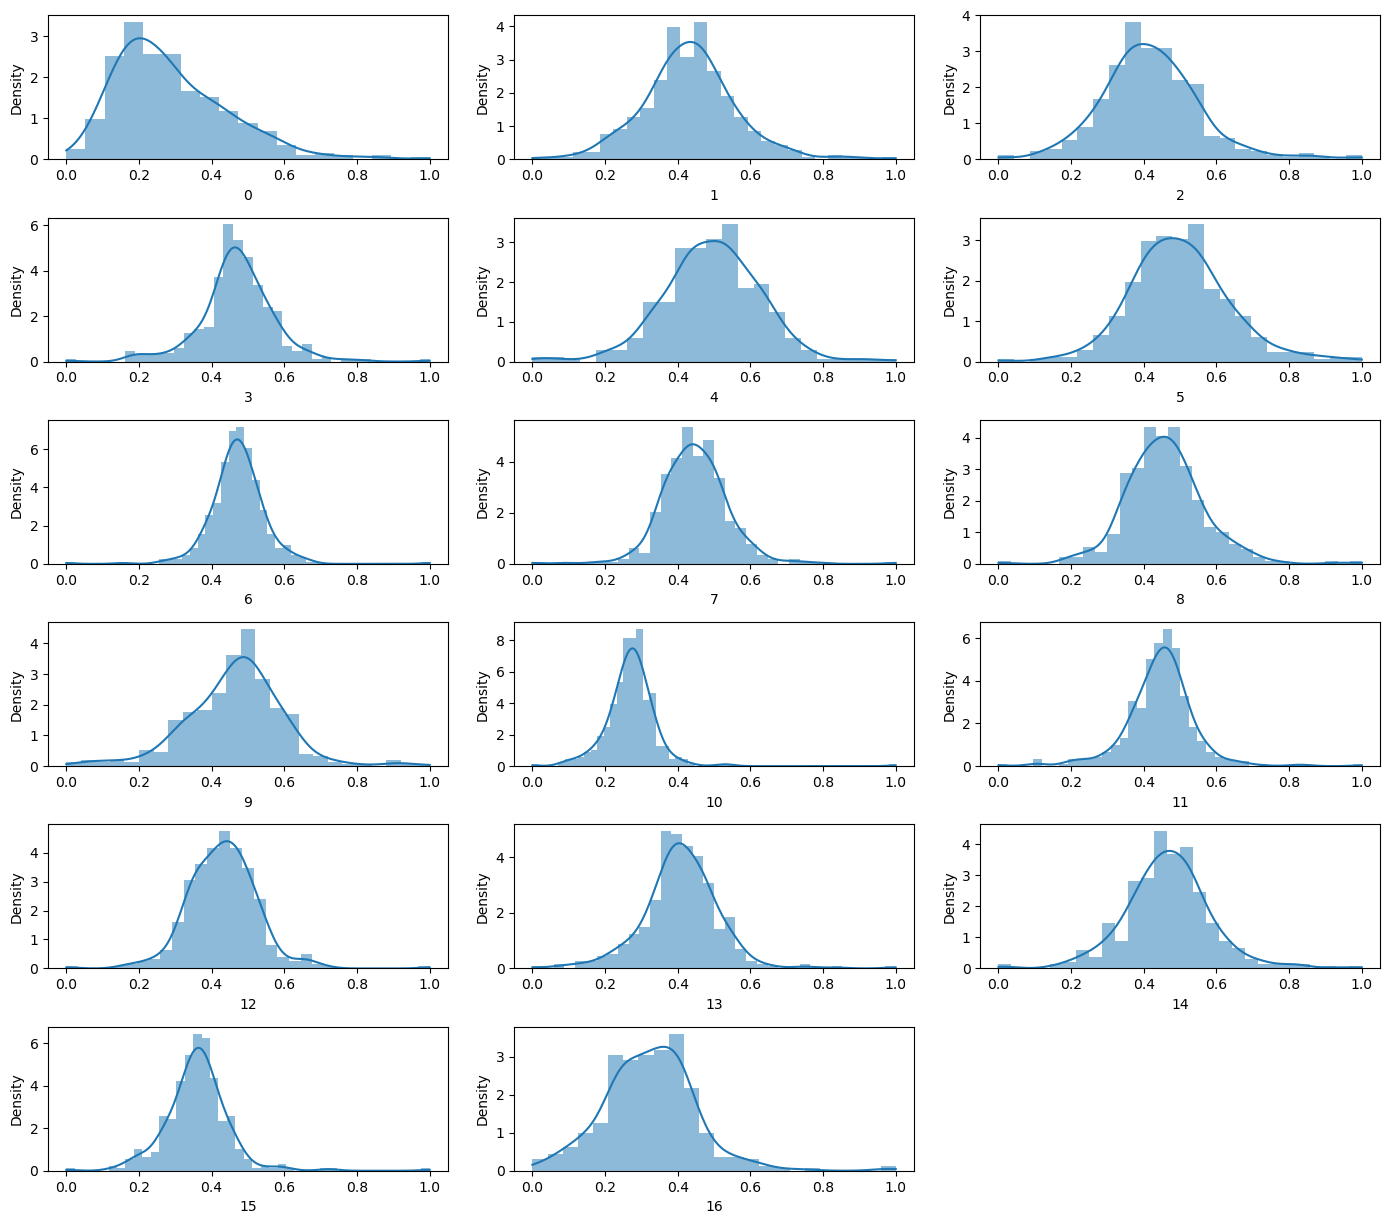

In [279]:
# kde plot for features after standardization and normalization
x_train_pca_df = pd.DataFrame(X_train_pca)
plt.figure(figsize = (14, 20))
for i,c in enumerate(x_train_pca_df.columns):
    if c != 'diagnosis':
        ax = plt.subplot(10, 3, i+1)
        sns.histplot(x_train_pca_df[c], kde=True, stat='density', linewidth=0)
        plt.xlabel(c)

plt.tight_layout()
plt.show()

In [280]:
from torch.utils.data import DataLoader, Dataset
from typing import Tuple

# create a custom dataset class
class BCWDataset(Dataset):
    def __init__(self, X_df:pd.DataFrame, y_df:pd.DataFrame) -> None:
        super().__init__()
        self.X = torch.tensor(X_df, dtype=torch.float)
        self.classes = torch.tensor(y_df, dtype=torch.float)
    
    def __len__(self):
        return len(self.classes)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], self.classes[index]

# turn raw data into datasets
train_dataset = BCWDataset(X_train_pca, y_train.to_numpy())
validation_dataset = BCWDataset(X_validation_pca, y_validation.to_numpy())
test_dataset = BCWDataset(X_test_pca, y_test.to_numpy())

# turn datasets into dataloaders
BATCH_SIZE = 16 
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# print out the first entry for training dataloader
sample_X, y = next(iter(train_dataloader))
print('Sample X:\n',sample_X[0])
print('Sample y:\n', y[0])

Sample X:
 tensor([0.8662, 0.6265, 0.0000, 0.2263, 0.2047, 0.4026, 0.5321, 0.7868, 0.3851,
        0.0682, 0.3216, 0.4626, 0.2821, 0.4379, 0.2887, 0.4823, 0.1227])
Sample y:
 tensor(1.)


---

# Modeling

We will build a simple feed forward neural network for binary classification. We will also introduce non-linearity to the model.

In [310]:
from typing import List, Union
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch import nn
import torchmetrics

class BreastCancerWisconsinBinaryClassifier(nn.Module):
    def __init__(self,
                 in_features:int,
                 out_features:int,
                 hidden_layers:int,
                 hidden_neurons:int,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # model architecture
        hidden_layers_list = []
        for _ in range(hidden_layers):
            hidden_layers_list.append(nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons))
            hidden_layers_list.append(nn.ReLU())

        self.layers = nn.Sequential(nn.Linear(in_features=in_features, out_features=hidden_neurons),
                                    nn.ReLU(),
                                    *hidden_layers_list,
                                    nn.Linear(in_features=hidden_neurons, out_features=out_features))
        
        # model loss, optimizer, metrics
        self.loss_fn = None
        self.optimizer = None
        self.metrics = None

    # compile model
    def compile(self, optimizer:torch.optim.Optimizer, loss_fn:nn.Module, metrics:List[torchmetrics.Metric]) -> None:
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.metrics = metrics
        self = torch.compile(self)
    
    def _fit_train(self, dataloader:torch.utils.data.DataLoader,device:Union[str, torch.device]):
        self.train()
        train_loss, train_metrics = 0, {}
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logits = self.forward(X).squeeze()
            loss = self.loss_fn(y_logits, y)
            train_loss += loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            y_pred_class = torch.round(torch.sigmoid(y_logits))
            for metric in self.metrics:
                if metric.__class__.__name__ in train_metrics.keys():
                    train_metrics[metric.__class__.__name__] += metric(
                        y_pred_class, y)
                else:
                    train_metrics[metric.__class__.__name__] = metric(
                        y_pred_class, y)
        train_loss = train_loss/len(dataloader)
        for metric in self.metrics:
            train_metrics[metric.__class__.__name__] /= len(dataloader)
        return train_loss, train_metrics
    
    def _fit_validate(self, dataloader:torch.utils.data.DataLoader, device:Union[str,torch.device]):
        self.eval()
        validation_loss, validation_metrics = 0, {}
        with torch.inference_mode():
            for X,y in dataloader:
                X, y = X.to(device), y.to(device)
                y_logits = self.forward(X).squeeze()
                loss = self.loss_fn(y_logits, y)
                validation_loss += loss
                validation_pred_class = torch.round(torch.sigmoid(y_logits))
                for metric in self.metrics:
                    if metric.__class__.__name__ in validation_metrics.keys():
                        validation_metrics[metric.__class__.__name__] += metric(
                            validation_pred_class, y)
                    else:
                        validation_metrics[metric.__class__.__name__] = metric(
                            validation_pred_class, y)
            validation_loss /= len(dataloader)
            for metric in validation_metrics.keys():
                validation_metrics[metric] /= len(dataloader)
        return validation_loss, validation_metrics
    
    # train model
    def fit(self,training_dl, validation_dl, epochs, device:Union[str, torch.device]='cpu') -> None:

        results = {'train loss': [],
                   'validation loss': []}
        for metric in self.metrics:
            results['train ' + metric.__class__.__name__] = []
            results['validation ' + metric.__class__.__name__] = []

        start_timer = timer()
        for epoch in tqdm(range(epochs)):
            train_loss, train_metrics = self._fit_train(dataloader=training_dl,
                                                        device=device)
            validation_loss, validation_metrics = self._fit_validate(dataloader=validation_dl,
                                                                     device=device)
            print(f'Epoch: {epoch+1}')
            train_metric_str = ' - '.join(
                [f'{metric}: {train_metrics[metric]:.4f}' for metric in train_metrics.keys()])
            print(
                f'Training loss: {train_loss:.4f} | Training Metrics: {train_metric_str}')
            test_metric_str = ' - '.join(
                [f'{metric}: {validation_metrics[metric]:.4f}' for metric in validation_metrics.keys()])
            print(
                f'Validation loss: {validation_loss:.4f} | Validation Metrics: {test_metric_str}\n')
            results['train loss'].append(train_loss.detach().numpy())
            results['validation loss'].append(validation_loss.detach().numpy())
            for metric in self.metrics:
                results['train ' + metric.__class__.__name__].append(
                    train_metrics[metric.__class__.__name__].detach().numpy())
                results['validation ' + metric.__class__.__name__].append(
                    validation_metrics[metric.__class__.__name__].detach().numpy())
        
        end_timer = timer()
        print(f'Total training time: {end_timer-start_timer:.2f} seconds.')
        return results
    
    def evaluate(self, dataloader:torch.utils.data.DataLoader, device:torch.device):
        test_loss, test_metrics = 0, {}
        test_pred_class_list = []
        self.eval()
        with torch.inference_mode():
            for X,y in tqdm(dataloader):
                X,y = X.to(device), y.to(device)
                y_logits = self.forward(X).squeeze()
                test_loss += self.loss_fn(y_logits, y)
                test_pred_class = torch.round(torch.sigmoid(y_logits))
                test_pred_class_list.append(test_pred_class)
                for metric in self.metrics:
                    if metric.__class__.__name__ in test_metrics.keys():
                        test_metrics[metric.__class__.__name__] += metric(
                            test_pred_class, y)
                    else:
                        test_metrics[metric.__class__.__name__] = metric(
                            test_pred_class, y)
            test_loss /= len(dataloader)
            for metric in test_metrics.keys():
                test_metrics[metric] /= len(dataloader)
            test_pred_tensor = torch.cat(test_pred_class_list)
        return test_loss, test_metrics, test_pred_tensor



    def forward(self, x:torch.Tensor):
        return self.layers(x)
        
        

In [318]:
model = BreastCancerWisconsinBinaryClassifier(in_features=len(sample_X[0]),
                                              out_features=1,
                                              hidden_layers=2,
                                              hidden_neurons=10).to(DEVICE)
model

BreastCancerWisconsinBinaryClassifier(
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [319]:
EPOCHS = 10
LEARNING_RATE = 0.01
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
metrics = [torchmetrics.Accuracy('binary')]
model.compile(optimizer,loss_fn, metrics)
model_results = model.fit(training_dl=train_dataloader,
                          validation_dl=validation_dataloader,
                          epochs=EPOCHS,
                          device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.6494 | Training Metrics: BinaryAccuracy: 0.6475
Validation loss: 0.6627 | Validation Metrics: BinaryAccuracy: 0.6225

Epoch: 2
Training loss: 0.6529 | Training Metrics: BinaryAccuracy: 0.6300
Validation loss: 0.6450 | Validation Metrics: BinaryAccuracy: 0.6225

Epoch: 3
Training loss: 0.5948 | Training Metrics: BinaryAccuracy: 0.6400
Validation loss: 0.5320 | Validation Metrics: BinaryAccuracy: 0.8975

Epoch: 4
Training loss: 0.3753 | Training Metrics: BinaryAccuracy: 0.8875
Validation loss: 0.2907 | Validation Metrics: BinaryAccuracy: 0.9100

Epoch: 5
Training loss: 0.2176 | Training Metrics: BinaryAccuracy: 0.9200
Validation loss: 0.2315 | Validation Metrics: BinaryAccuracy: 0.8575

Epoch: 6
Training loss: 0.1382 | Training Metrics: BinaryAccuracy: 0.9425
Validation loss: 0.2123 | Validation Metrics: BinaryAccuracy: 0.9350

Epoch: 7
Training loss: 0.1443 | Training Metrics: BinaryAccuracy: 0.9400
Validation loss: 0.1678 | Validation Metrics: BinaryAccuracy: 

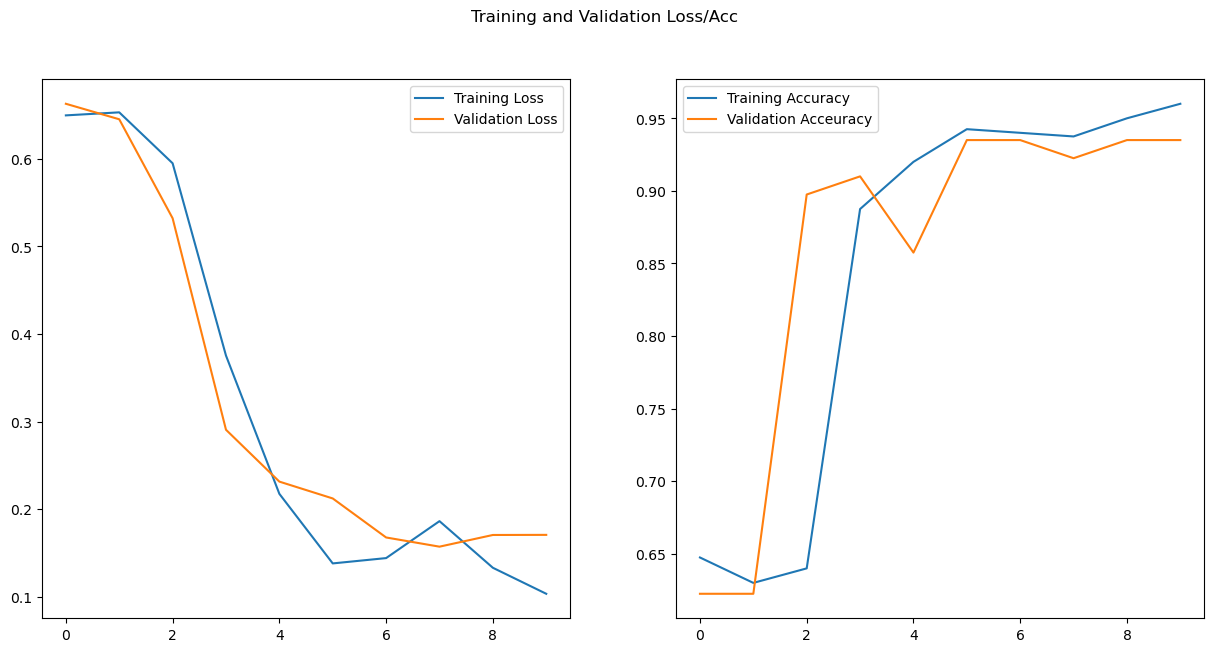

In [320]:
epochs = list(range(EPOCHS))
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(epochs, model_results['train loss'], label='Training Loss')
plt.plot(epochs, model_results['validation loss'], label='Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, model_results['train BinaryAccuracy'], label='Training Accuracy')
plt.plot(epochs, model_results['validation BinaryAccuracy'], label='Validation Acceuracy')
plt.legend()
plt.suptitle('Training and Validation Loss/Acc');

In [321]:
test_loss, test_acc, test_pred_tensor = model.evaluate(test_dataloader, device=DEVICE)
test_loss, test_acc

  0%|          | 0/8 [00:00<?, ?it/s]

(tensor(0.1675), {'BinaryAccuracy': tensor(0.9062)})

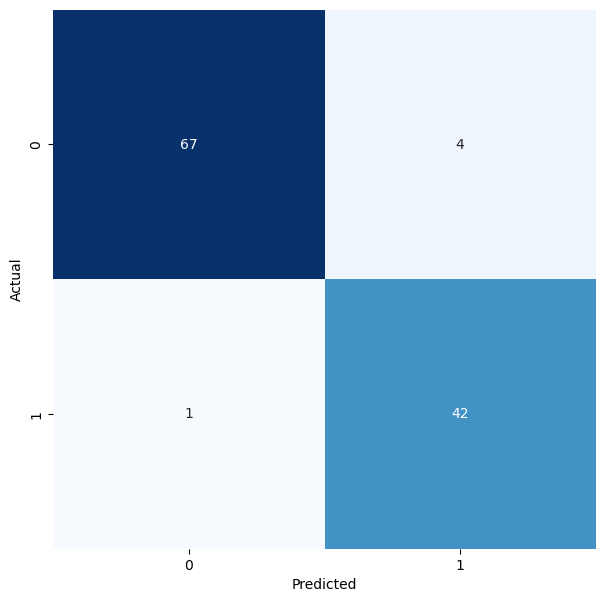

In [322]:
confusion_matrix = torchmetrics.ConfusionMatrix('binary')
confusion_matrix = confusion_matrix(test_pred_tensor, test_dataset.classes)
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual');